In [34]:
import numpy as np 
from numpy import random
import pandas as pd 
from collections import deque
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym


Task 1: Tabular Q-Learning

In [35]:
def init_q_table(n_states, n_actions):
    return np.zeros((n_states, n_actions))
def q_update(Q, s, a, r, s_next, alpha, gamma):
    s = int(s)
    a = int(a)
    s_next = int(s_next)
    Q[s][a]=Q[s][a]+alpha*(r+(gamma*max(Q[s_next]))-Q[s][a])
    return Q


Task 2: ε-Greedy Policy on a Custom GridWorld

In [36]:

class GridWorld:
    def __init__(self):
        self.grid_size=4
        self.n_states=16
        self.actions=[0,1,2,3]
        self.terminal_states=[0,3,11,15]
        self.state=0
        self.row=self.state/4
        self.col=self.state%4
    def first_state(self):
        self.state=random.randint(0,15)
        return self.state
    def action_(self,action):
        self.row=self.state//4
        self.col=self.state%4
        next_state=self.state
        if action==0 and self.row>0:
            next_state-=4
        elif action==1 and self.row<3:
            next_state+=4
        elif action ==2 and self.col>0:
            next_state-=1
        elif action==3 and self.col<3:
            next_state+=1
        reward=-next_state
        if next_state in self.terminal_states:
            done=1
        else:
            done=0
        self.state=next_state
        return next_state,reward,done
                
    
    


In [37]:
def select_action(Q,state,epsilon):
    if random.random()< epsilon:
        return random.randint(0,3)
    else:
        return np.argmax(Q[state])

In [38]:
reward_arr=[]
def training(epsilon):
    n=500
    alpha=0.1
    gamma=0.1
    env=GridWorld()
    Q=init_q_table(16,4)
    for x in range(n):
        state=env.first_state()
        done=0
        temp=0
        while done==0:
            action=select_action(Q,state,epsilon)
            next_state,reward,done=env.action_(action)
            Q=q_update(Q,state,action,reward,next_state,alpha,gamma)
            state=next_state
            temp+=reward
        reward_arr.append(temp)
    return reward_arr
epsilon_1=training(0.1)
reward_arr=[]
epsilon_2=training(0.2)
x=[i for i in range(1,501)]

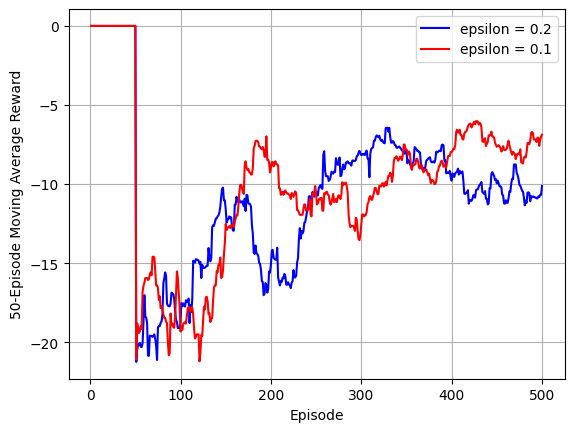

In [39]:
sum=0
moving_avg1=[]
for i in range(50):
    sum+=epsilon_1[i]
    moving_avg1.append(0)
for i in range(450):
    moving_avg1.append(sum/50)
    sum-=epsilon_1[i]
    sum+=epsilon_1[i+50]
sum=0
moving_avg2=[]
for i in range(50):
    sum+=epsilon_2[i]
    moving_avg2.append(0)
for i in range(450):
    moving_avg2.append(sum/50)
    sum-=epsilon_2[i]
    sum+=epsilon_2[i+50]
plt.plot(x,moving_avg2,label='epsilon = 0.2',color='blue')
plt.plot(x,moving_avg1,label='epsilon = 0.1',color='red')
plt.xlabel("Episode")
plt.ylabel("50-Episode Moving Average Reward")
plt.legend()
plt.grid(True)
plt.show()

On average, the moving average with epsilon=0.1 has better rewards compared to that of epsilon=0.2. Which shows that the model works better when its actions are less random (at least for 500 episodes).

Task 3 : Experience Replay Buffer

In [40]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity) 
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self,batch_size):
        batch = random.sample(self.buffer, batch_size)
        state,action,reward,next_state,done=zip(*batch)
        states_array = np.array(state)
        actions_array = np.array(action)
        rewards_array = np.array(reward, dtype=np.float32)      
        next_states_array = np.array(next_state)
        dones_array = np.array(done, dtype=np.bool_)
        return (states_array, actions_array, rewards_array, next_states_array, dones_array)
buffer=ReplayBuffer(capacity=100)
for i in range(100):
    buffer.push(np.random.randint(0,16),np.random.randint(0,4),np.random.uniform(-1,1),np.random.randint(0,16), np.random.choice([True, False]) )
(states, actions, rewards, next_states, dones) = buffer.sample(32)
print("Shapes:")
print("States:", states.shape)
print("Actions:", actions.shape)
print("Rewards:", rewards.shape)
print("Next States:", next_states.shape)
print("Dones:", dones.shape)

print("\nData Types:")
print("States:", states.dtype)
print("Actions:", actions.dtype)
print("Rewards:", rewards.dtype)
print("Next States:", next_states.dtype)
print("Dones:", dones.dtype)
    

Shapes:
States: (32,)
Actions: (32,)
Rewards: (32,)
Next States: (32,)
Dones: (32,)

Data Types:
States: int64
Actions: int64
Rewards: float32
Next States: int64
Dones: bool


Task 4: Deep Q-Network with Target Copy

In [41]:
class DQNPolicy(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNPolicy, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
class DQNTarget(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNTarget, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())



Task 5: Full DQN Training Loop on CartPole-v1


In [42]:
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

policy_net = DQNPolicy(input_dim, output_dim)
target_net = DQNTarget(input_dim, output_dim)
update_target(policy_net, target_net)

optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

buffer = ReplayBuffer(10000)

N = 5000
X = 10
M = 500
gamma = 0.1

batch_size = 100

episode_rewards=[]

epsilon = 1
epsilon_min = 0.01
for episode in range(N):
    state = env.reset()[0]
    total_reward = 0
    done = False

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state_tensor)
            action = q_values.max(1)[1].item()
        next_state,reward,terminated,truncated,info= env.step(action)
        done=terminated or truncated
        buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if len(buffer.buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)

            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones).unsqueeze(1)

            q_values = policy_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
            targets = rewards + gamma * next_q_values * (1 - dones)

            loss = loss_fn(q_values, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    episode_rewards.append(total_reward)
    epsilon = max(epsilon_min, epsilon - (1.0 - epsilon_min) / M)
    if episode % X == 0:
        update_target(policy_net, target_net)
    


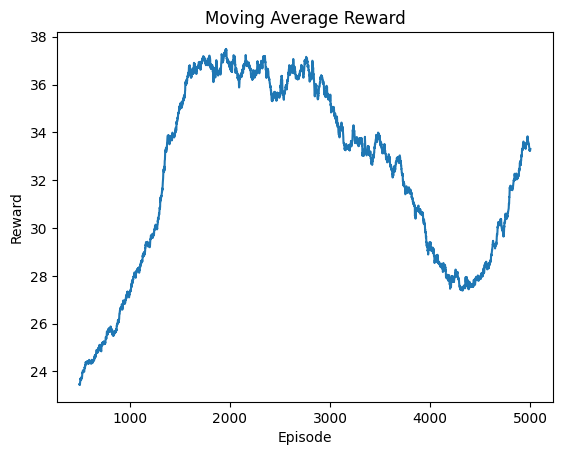

In [43]:
window=int(N/10)
data = pd.Series(episode_rewards)
moving_avg= data.rolling(window=window).mean()
plt.plot(moving_avg)
plt.title("Moving Average Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [44]:
c=0
for i in episode_rewards:
    if(i>=195):
        c+=1
print(f"Percentage ={c/len(episode_rewards)}")

Percentage =0.0004
